# Similarity of the cities

<p>After preparing data and calculating the frequencies of the words and phrases in the business categories, it is time to calculate similarity.</p>
<p> 
I picked the simple approach, making a corpus of the words and then clustering that corpus. And I'll start with gensim module. </p>

In [1]:
from gensim import corpora
import pickle
import numpy as np
import scipy
from matplotlib import pyplot as plt
import gensim
import pandas as pd
import random
import math
import os
import sys

/Users/Lexa/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


I'll start with the single word categories. 

In [51]:
pkl_file1 = open('out_cityCatTop.pkl', 'rb')
topCateg= pickle.load (pkl_file1)
pkl_file1.close()

Cleaning of the data is not completed. Now, I need to remove common short words and special symbols. Both do not have a specific meaning when we consider the business categories, but due to descriptive value of the words and characters they might have a high frequency. 

In [52]:
cities=topCateg.keys()
stoplist = set('for a of the and to in ( )'.split())
texts=[]
for cit in cities:
    cat=topCateg[cit]
    texts.append([tup[0] for tup in cat if tup[0] not in stoplist])

Next step is to make a corpus of the words. <br>
I'm starting by making a dictionary that assigns a number to a word.

In [53]:
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

Dictionary(163 unique tokens: [u'shop', u'venu', u'salon', u'nurseri', u'mexican']...)


Now I'm making vectors.

In [54]:
corpus=[]

for cit in cities:
    cat=topCateg[cit]
    new_doc = [tup[0] for tup in cat if tup[0] not in stoplist]
    new_vec = dictionary.doc2bow(new_doc)
    corpus.append(new_vec) 

corpora.MmCorpus.serialize('/tmp/deerwester.mm', corpus)  # store to disk, for later use

<p>I plan to look for similarity using clustering algorithm. So, next step is turning the corpus in a numpy matrix.</p>
<p>
Math is really awesome, so finding a way to turn your words into the numbers and then process those numbers is my favorite way of analysis. </p>

In [55]:
Nmat = gensim.matutils.corpus2dense(corpus, num_terms=163)
Nmat1= Nmat.transpose()
df=pd.DataFrame(Nmat1)
df['city']=cities
print df.head(5)
print len(cities)

     0    1    2    3    4    5    6    7    8    9         ...           154  \
0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         ...           0.0   
1  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0         ...           0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0         ...           0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0         ...           0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         ...           0.0   

   155  156  157  158  159  160  161  162                 city  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  dollard-des-ormeaux  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0            stanfield  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    upper saint clair  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0           south gyle  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          dalgety bay  

[5 rows x 164 columns]
362


And now applying the simplest clustering algorithm, K-means.

In [61]:
from scipy.cluster.vq import kmeans, vq

test=range(163)
colu=[str(x) for x in test]

words = Nmat1 
N = len(words)
k = 70
i = 50

centroids = kmeans(words, k, iter=i)
a=centroids[0]

test=vq(words,a)


So let us see one of the cluster. 

In [62]:
test1=test[0]
test2=test[1]

df['cluster']=test1
df['distance']=test2
tee={'city':df['city'], 'cluster': df['cluster'], 'distance':df['distance']}
df2=pd.DataFrame(data=tee)


clu=df2[df2['city']=='pittsburgh']['cluster'].values
clus=int(clu)

print df2[df2['cluster']==clus]

                      city  cluster  distance
18          san tan valley        3  1.052627
19                carefree        3  0.743283
24               youngtown        3  1.052627
66          castle shannon        3  0.941171
99                maricopa        3  0.880166
143             pittsburgh        3  0.880166
174                 rankin        3  1.489676
205       chandler-gilbert        3  1.526515
207         1023 e frye rd        3  1.413122
223             charlotte         3  1.413122
229              ahwatukee        3  0.941171
250  nellis air force base        3  1.489676
263                seattle        3  1.526515
265              ettlingen        3  0.880166
271           indian trail        3  1.104145
333        apache junction        3  0.574671
350              karlsruhe        3  0.880166
355               carnegie        3  0.880166


### Of course, I would like to see this graphically. 
<p> The vector space of my corpus has 163 dimensions. Something that we cannot even imagine not to mention visually present.</p>
<p>So, instead, I will distribute clusters in the grid and assign distance of the grid point based on their cluster distance and random angle I'll assign to the point. Initially, I tried random angle just to make sure that cities do not overlap in my graph, but since human eye tends to see patterns where patterns do not exist, I limited the angle to 45 degrees only. This will align cities in the cluster in diagonal, at the 2D distances respective on their 163D distance from the cluster center. Of course, some cities will overlap with this method.</p>

In [66]:
x=range(k/10)
x=[t*10 for t in x]
y=range(10)
y=[t*10 for t in y]

clusterCoor=[]

for xc in x:
    for yc in y:
        clusterCoor.append((xc,yc))

clust=pd.DataFrame(data=clusterCoor)
clust['cluster']=range(k)



clu=df2['cluster']
dis=df2['distance']
xci=[]
yci=[]

for i in range(len(clu)):
    cl=clu[i]
    dist=dis[i]
    clRow=clust[clust['cluster']==cl]
    xC=int(clRow[0].values)
    yC=int(clRow[1].values)
    angle=45 #random.randint(0,90)
    xci.append((dist* math.cos(angle))+xC)
    yci.append((dist *math.sin(angle))+yC) 
    
df2['xCoor']=xci
df2['yCoor']=yci

print df2.head(6)

                  city  cluster  distance      xCoor      yCoor
0  dollard-des-ormeaux       36  1.080124  30.567413  60.919081
1            stanfield       22  0.974279  20.511810  20.829017
2    upper saint clair        0  0.400000   0.210129   0.340362
3           south gyle       29  0.899954  20.472766  90.765774
4          dalgety bay       31  1.000000  30.525322  10.850903
5              madison       26  0.598352  20.314327  60.509140


Now, I can plot the grid. 

In [67]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


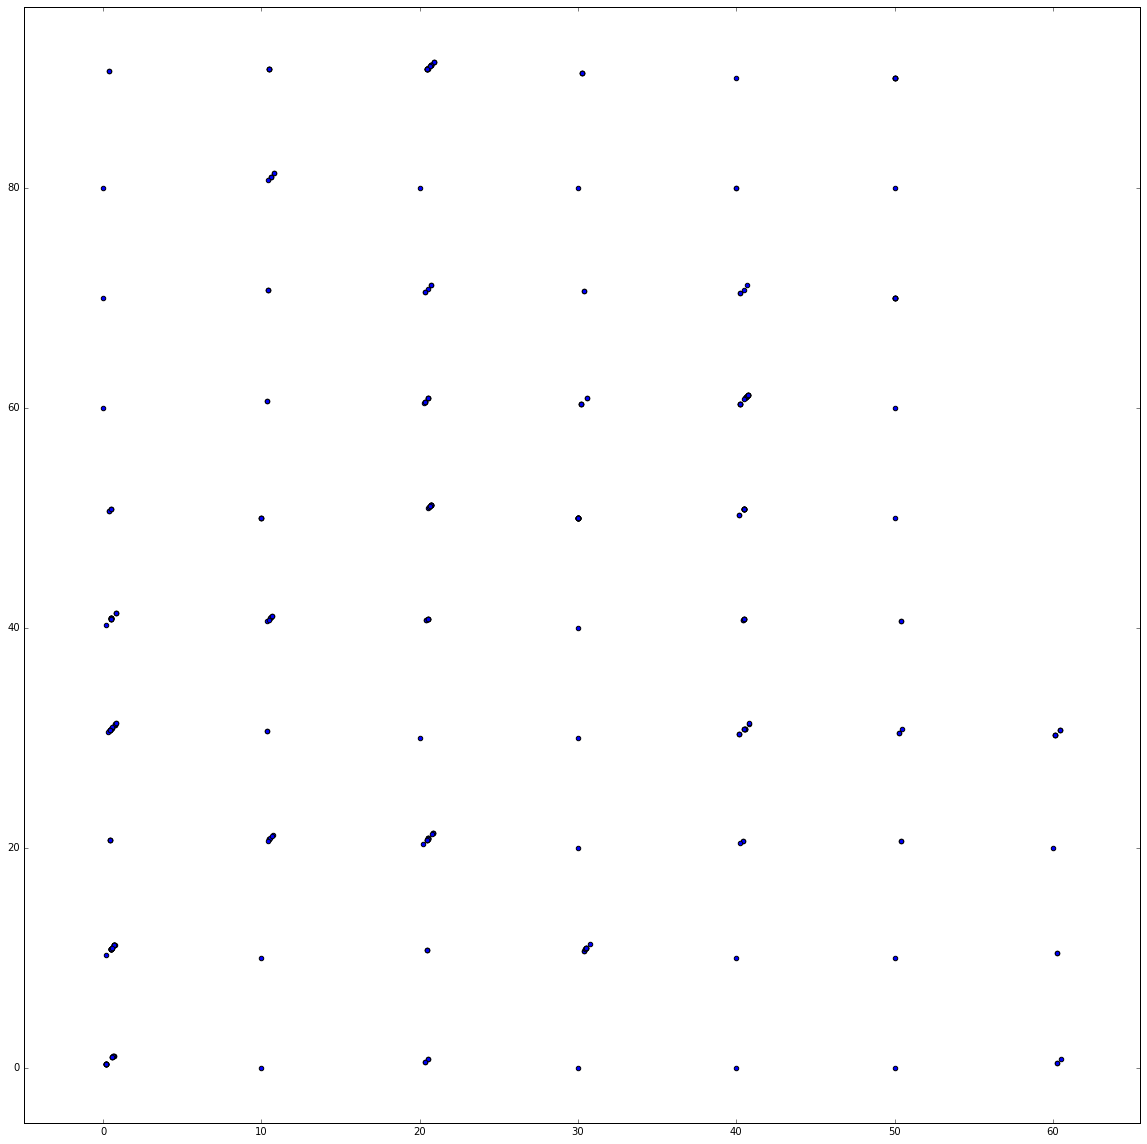

In [68]:
x= df2['xCoor']
y= df2['yCoor']

plt.figure(figsize=(20, 20), dpi=100)
plt.scatter(x,y)
plt.xlim(x.min()-5,x.max()+5)
plt.ylim(y.min()-5,y.max()+5)
plt.show()

<p>This figure does not tell us much. Unless we take in the consideration the fact that majority of the Yelp data consist of cities with the university. This particular data set is a combination of the dataset offered to college students, the one that consists of the urban areas around the universities themselves and just a few other complete urban areas. </p>
<p>Thus, I'm expecting the results to show a bias towards several huge clusters. After all, around the universities, one can expect certain prevalent types of business, the ones that offer services specific to the academic settings.</p>

In [69]:
df4=df2[df2['cluster']==clus]
x1= df4['xCoor']
y1= df4['yCoor']
df5=df4.loc[df4['distance'].idxmin()]
closestCity=df5['city']
xclos=df5['xCoor']
yclos=df5['yCoor']
df6=df4.loc[df4['distance'].idxmax()]
furCity=df6['city']
xfur=df6['xCoor']
yfur=df6['yCoor']

In [70]:
cenx=int(x1.min()-x1.min()%10.)
ceny=int(y1.min()-y1.min()%10.)
print cenx,ceny

0 30


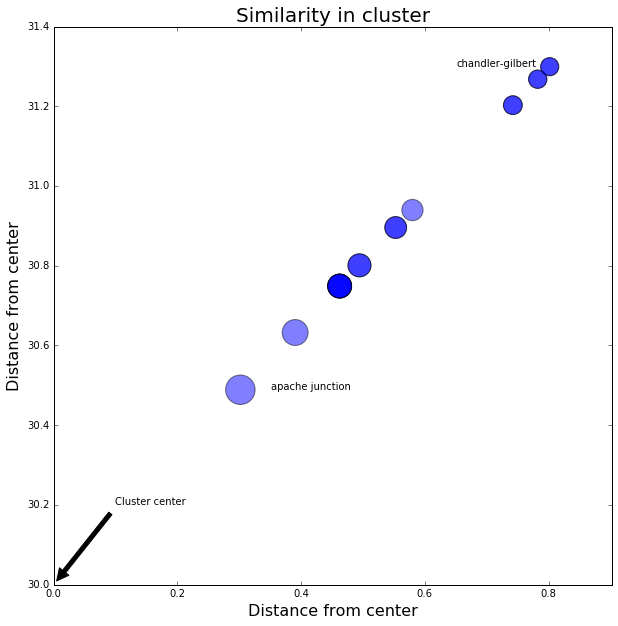

In [72]:
plt.figure(figsize=(10, 10), dpi=100)
df_scatter = plt.scatter(x1,y1, c='b', alpha=.5, s=500/df4['distance'])
plt.title( 'Similarity in cluster', fontsize=20)
plt.xlabel('Distance from center', fontsize=16)
plt.ylabel('Distance from center', fontsize =16)
plt.xlim(cenx,x1.max()+0.1)
plt.ylim(ceny,y1.max()+0.1)
plt.annotate('Cluster center', xy=(cenx, ceny), xytext=(cenx+0.1, ceny+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.text(xclos+0.05,yclos, closestCity)
plt.text(xfur-0.15,yfur, furCity)
plt.show()

<p>Although I got neat result, I personally do not like it.</p>
<p>During making of corpus vectors ended up having more than 100 dimensions, and I have a limited number of cities. This makes these results highly suspicious. It is never good when one has features and data points that are in the same order of magnitude of numbers. There is no way one can get statistically significant results. (Unless your goal is to use statistic to lie ;-) ) </p>
<p>I took only 3 top categories for each city to reduce the number of dimensions, but further reduction is not possible because when I reduce to two or one business category, then I get too dense clusters.</p>
<p>Restoraunts as most common business is a consequence of today's world, where online business is more prevalent. Thus, I have to have 3 categories at least in a previous analysis. Otherwise, most of the cities would end up same.</p>
<p>I'll test this with analyzing of common phrases. There I can reduce features dimensions taking only one or two phrases per city. </p>
# Similarity of cities based on most common phrases

<p> So now, instead comparing single words used to describe business categories in cities, I'm using phrases.</p>
<p>First, I'll start with analysis of two-words phrases and basically repeat above analysis.</p>


In [102]:
pkl_file1 = open('out_cityCatBigramTop.pkl', 'rb')
topCateg= pickle.load (pkl_file1)
pkl_file1.close()

In [103]:
cities=topCateg.keys()
stoplist = set('for a of the and to in ( )'.split())
texts=[]
for cit in cities:
    cat=topCateg[cit]
    texts.append([tup[0] for tup in cat if tup[0] not in stoplist])

In [104]:
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

Dictionary(99 unique tokens: [u'shop', u'mexican', u'german', u'asian', u'flavor']...)


And this might be promising. Now with 2 top phrases, I will have vectors that have 99 dimensions. Barely out of the order of magnitude of the data points.  

In [105]:
corpus=[]

for cit in cities:
    cat=topCateg[cit]
    new_doc = [tup[0] for tup in cat if tup[0] not in stoplist]
    new_vec = dictionary.doc2bow(new_doc)
    corpus.append(new_vec) 

corpora.MmCorpus.serialize('/tmp/deerwester2.mm', corpus)  # store to disk, for later use
Nmat = gensim.matutils.corpus2dense(corpus, num_terms=99)
Nmat1= Nmat.transpose()
df=pd.DataFrame(Nmat1)
df['city']=cities

Now off to clustering.

In [113]:
test=range(99)
colu=[str(x) for x in test]

words = Nmat1 
N = len(words)
k = 50
i = 100

centroids = kmeans(words, k, iter=i)
a=centroids[0]

test=vq(words,a)

In [121]:
test1=test[0]
test2=test[1]

df['cluster']=test1
df['distance']=test2
tee={'city':df['city'], 'cluster': df['cluster'], 'distance':df['distance']}
df2=pd.DataFrame(data=tee)


clu=df2[df2['city']=='los angeles']['cluster'].values
clus=int(clu)

print df2[df2['cluster']==clus]

                        city  cluster  distance
33   sainte-anne-de-bellevue        5       0.0
36         robinson township        5       0.0
61                  edgewood        5       0.0
69           south las vegas        5       0.0
179              los angeles        5       0.0
187              pierrefonds        5       0.0
211                kitchener        5       0.0
235                     etna        5       0.0
241                  neuburg        5       0.0
254                 waunakee        5       0.0
283              gold canyon        5       0.0
291            le vieux-port        5       0.0
324           west homestead        5       0.0
331        north queensferry        5       0.0


<p>Pay attention to the distance in this cluster. Every single city has exactly the same vector in corpus. That's why distance for each city is 0. This is because I'm using only one phrase.</p>
<p>Let us see how all clusers look together. </p>

In [122]:
x=range(k/10)
x=[t*10 for t in x]
y=range(10)
y=[t*10 for t in y]

clusterCoor=[]

for xc in x:
    for yc in y:
        clusterCoor.append((xc,yc))

clust=pd.DataFrame(data=clusterCoor)
clust['cluster']=range(k)



clu=df2['cluster']
dis=df2['distance']
xci=[]
yci=[]

for i in range(len(clu)):
    cl=clu[i]
    dist=dis[i]
    clRow=clust[clust['cluster']==cl]
    xC=int(clRow[0].values)
    yC=int(clRow[1].values)
    angle=45 #random.randint(0,90)
    xci.append((dist* math.cos(angle))+xC)
    yci.append((dist *math.sin(angle))+yC) 
    
df2['xCoor']=xci
df2['yCoor']=yci

print df2.head(6)

                  city  cluster  distance      xCoor      yCoor
0  dollard-des-ormeaux       29  0.000000  20.000000  90.000000
1            stanfield       12  0.000000  10.000000  20.000000
2    upper saint clair        0  0.998398   0.524480   0.849540
3           south gyle        0  0.096023   0.050443   0.081706
4          dalgety bay        0  0.985877   0.517903   0.838886
5              madison        0  0.985877   0.517903   0.838886


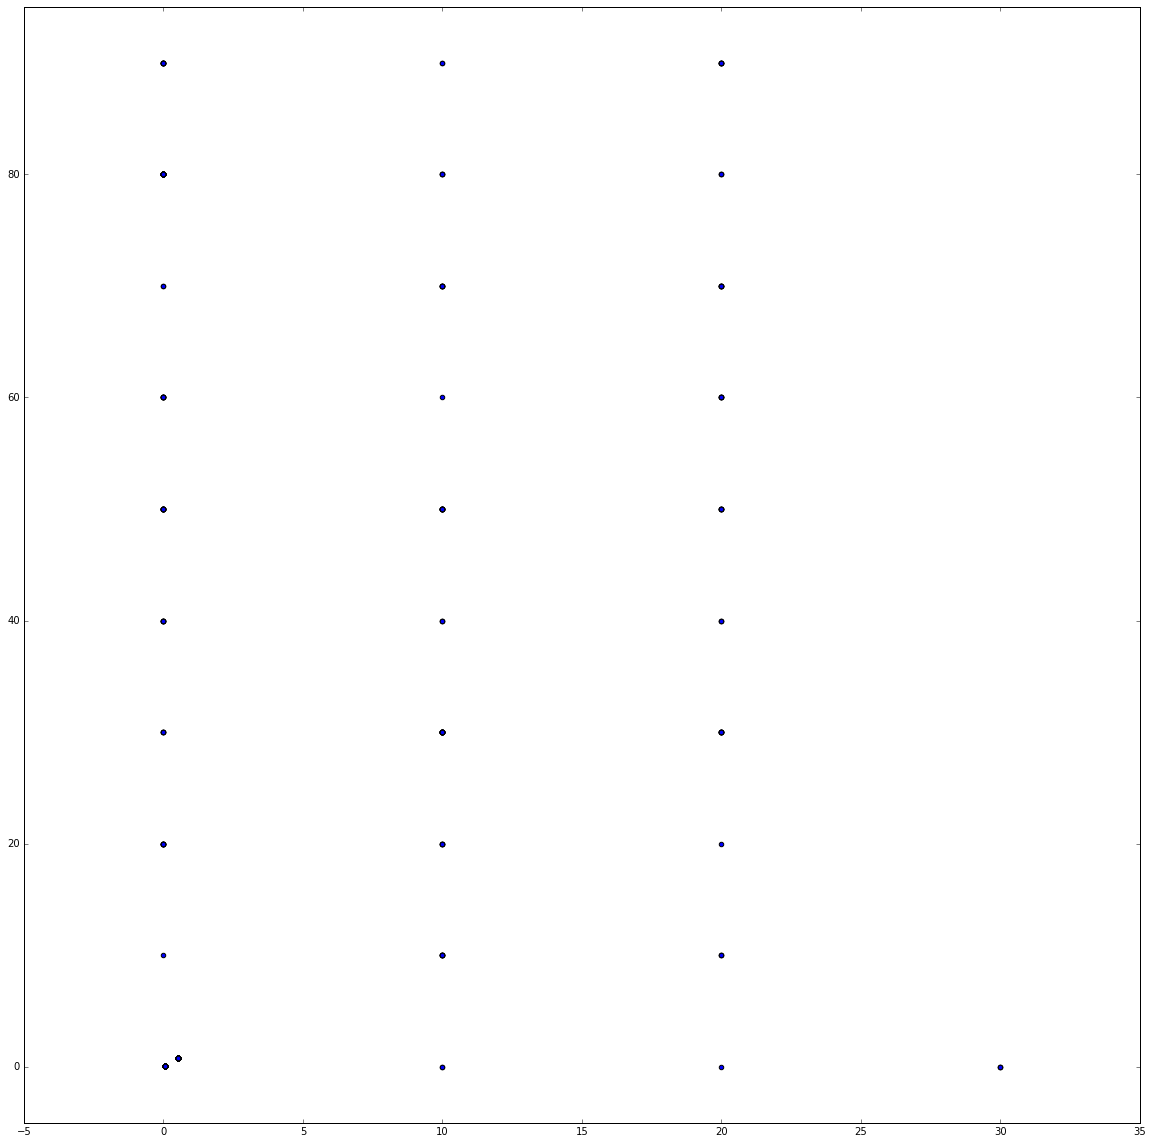

In [123]:
x= df2['xCoor']
y= df2['yCoor']

plt.figure(figsize=(20, 20), dpi=100)
plt.scatter(x,y)
plt.xlim(x.min()-5,x.max()+5)
plt.ylim(y.min()-5,y.max()+5)
plt.show()

<p>Unfortunately, only one cluster shows a bit of difference .</p>
<p>Let us see is situation more interesting when I use phrase of 3 words </p>
## Similarity based on triple word phrase

In [124]:
pkl_file1 = open('out_cityCatTrigramTop.pkl', 'rb')
topCateg= pickle.load (pkl_file1)
pkl_file1.close()

In [125]:
cities=topCateg.keys()
stoplist = set('for a of the and to in ( )'.split())
texts=[]
for cit in cities:
    cat=topCateg[cit]
    texts.append([tup[0] for tup in cat if tup[0] not in stoplist])

dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

Dictionary(105 unique tokens: [u'shop', u'nurseri', u'mexican', u'german', u'horseback']...)


In [127]:
corpus=[]

for cit in cities:
    cat=topCateg[cit]
    new_doc = [tup[0] for tup in cat if tup[0] not in stoplist]
    new_vec = dictionary.doc2bow(new_doc)
    corpus.append(new_vec) 

corpora.MmCorpus.serialize('/tmp/deerwester3.mm', corpus)  # store to disk, for later use
Nmat = gensim.matutils.corpus2dense(corpus, num_terms=105)
Nmat1= Nmat.transpose()
df=pd.DataFrame(Nmat1)
df['city']=cities

In [128]:
test=range(105)
colu=[str(x) for x in test]

words = Nmat1 
N = len(words)
k = 50
i = 100

centroids = kmeans(words, k, iter=i)
a=centroids[0]

test=vq(words,a)

In [129]:
test1=test[0]
test2=test[1]

df['cluster']=test1
df['distance']=test2
tee={'city':df['city'], 'cluster': df['cluster'], 'distance':df['distance']}
df2=pd.DataFrame(data=tee)


clu=df2[df2['city']=='los angeles']['cluster'].values
clus=int(clu)

print df2[df2['cluster']==clus]

                city  cluster  distance
61          edgewood        7       0.0
69   south las vegas        7       0.0
179      los angeles        7       0.0
187      pierrefonds        7       0.0
241          neuburg        7       0.0
254         waunakee        7       0.0
305         kirkland        7       0.0
319         wittmann        7       0.0
324   west homestead        7       0.0


<p> Again similar, distance is 0 for all cities, but this time, we have less cities in cluster. That is progress.</p>


In [130]:
x=range(k/10)
x=[t*10 for t in x]
y=range(10)
y=[t*10 for t in y]

clusterCoor=[]

for xc in x:
    for yc in y:
        clusterCoor.append((xc,yc))

clust=pd.DataFrame(data=clusterCoor)
clust['cluster']=range(k)



clu=df2['cluster']
dis=df2['distance']
xci=[]
yci=[]

for i in range(len(clu)):
    cl=clu[i]
    dist=dis[i]
    clRow=clust[clust['cluster']==cl]
    xC=int(clRow[0].values)
    yC=int(clRow[1].values)
    angle=45 #random.randint(0,90)
    xci.append((dist* math.cos(angle))+xC)
    yci.append((dist *math.sin(angle))+yC) 
    
df2['xCoor']=xci
df2['yCoor']=yci


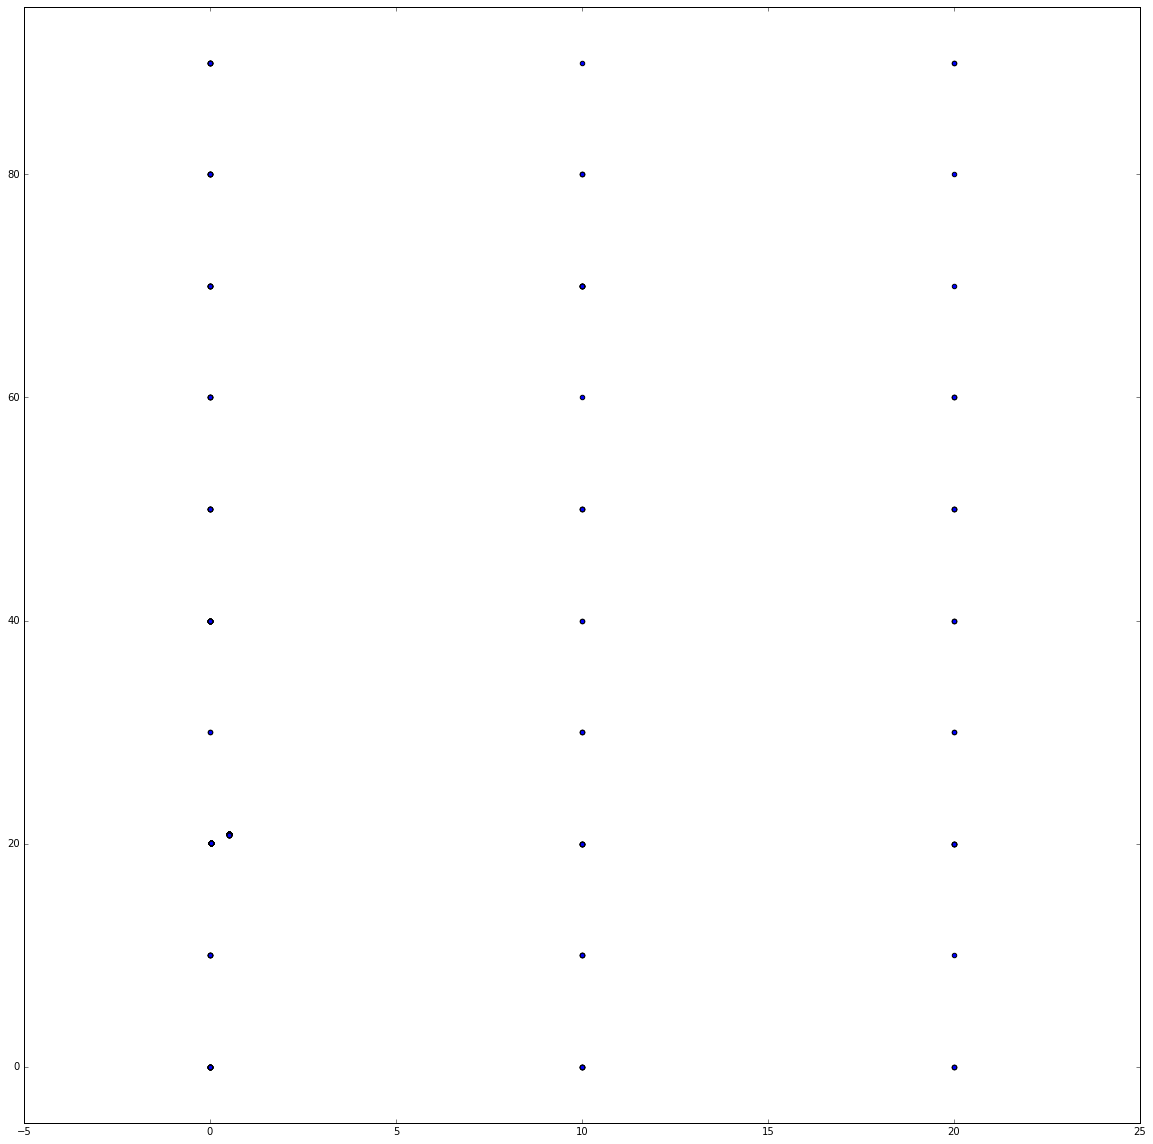

In [131]:
x= df2['xCoor']
y= df2['yCoor']

plt.figure(figsize=(20, 20), dpi=100)
plt.scatter(x,y)
plt.xlim(x.min()-5,x.max()+5)
plt.ylim(y.min()-5,y.max()+5)
plt.show()

<p>And of course, loads of overlapping in clusters here too.</p>
<p> Even one phrase is significant in deciding about business, but I still do not like the fact that even with reducing to one top phrase I end up having so many overlapping cities.</p>
<p>The final conclusion is that k-means simply do not work for this data. I will try this analysis with a different method. My next method to try is hierarchical clustering. </p>